#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

In [ ]:
!pip install pandas
!pip install holidays
!pip install typing
!pip install re
!pip install warnings
!pip install collections
!pip install numpy
!pip install pandas
!pip install matplotlib
!pip install statsmodels
!pip install sklearn
!pip install catboost
!pip install optuna
!pip install itertools

ERROR: Could not find a version that satisfies the requirement re (from versions: none)
ERROR: No matching distribution found for re
ERROR: Could not find a version that satisfies the requirement warnings (from versions: none)
ERROR: No matching distribution found for warnings
ERROR: Could not find a version that satisfies the requirement collections (from versions: none)
ERROR: No matching distribution found for collections
ERROR: Could not find a version that satisfies the requirement itertools (from versions: none)
ERROR: No matching distribution found for itertools


In [ ]:
import pandas as pd
import holidays
from typing import Union

import re
import warnings
from collections import Counter
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error,make_scorer
from sklearn.model_selection import train_test_split,GridSearchCV, TimeSeriesSplit, RandomizedSearchCV, cross_val_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from catboost import CatBoostRegressor
import optuna

from itertools import product


In [ ]:
warnings.filterwarnings("ignore")


## Подготовка

In [ ]:
data = pd.read_csv('/datasets/taxi.csv',parse_dates=True,index_col=0)

In [ ]:
data.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [ ]:
# функция для подсчетов типов
def counter_of_type(data):
    return Counter(data.dtypes)


In [ ]:
# Функция для ознакомления с данными
def preview(data,n_row=4,
             head=True,
             info=True,
             columns=True,
             shape=True,
             isna=True,
             duplicated=True,
             dtypes_=True,
            describe_=True,
           clear_duples=True,
           lower_and_sep_col=True):
    global dct_nan
    global df_nan_columns
    dct_nan = {}
    if head:
        print(f'First {n_row} row(s) in the head of data')
        display(data.head(n_row))
        print('-'*30)
    if info:
        print('Data Information:')
        display(data.info())
        print('-'*30)
    if columns:
        print('Data columns:')
        display(data.columns)
        if lower_and_sep_col:
            COLUMN_REG = "(\w)([A-Z])"
            repl = r"\1_\2"
            data.columns = list(map(lambda x: re.sub(COLUMN_REG,repl,x).lower(),data.columns))
            print('Lowered and sepperated by words columns:')
            print(data.columns)
            print('-'*30)
    if shape:
        print('Data shape:')
        display(data.shape)
        print('-'*30)
    if isna:
        print('Data isna by row mean:')
        display(data.isna().mean())
        print()
        tmp = data.isna().mean()
        for i in range(len(tmp)):

            if tmp[i] > 0:
                dct_nan[tmp.index[i]] = tmp[i]
        if tmp.sum() > 0:
            df_nan_columns = pd.DataFrame.from_dict(dct_nan.items())
            df_nan_columns.columns = ['column','rate_of_nan']
            display(df_nan_columns)
        print('-'*30)
    if duplicated:
        print('Data clear duplicates sum:')
        duplets = data.duplicated().sum()
        display(duplets)
        if duplets >1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicates'.format(duplets))
        elif duplets == 1 and clear_duples:
            data.drop_duplicates(inplace=True)
            print('Successful delete of {0} duplicate'.format(duplets))
        print('-'*30)
    if dtypes_:
        print('Data dtypes:')
        display(data.dtypes)
        print('Number of each type:')
        print(counter_of_type(data))
        print('-'*30)
    if describe_:
        print('Major statistics for data:')
        display(data.describe())


In [ ]:
preview(data,clear_duples=False,duplicated=False)

First 4 row(s) in the head of data


,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20


------------------------------
Data Information:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


None

------------------------------
Data columns:


Index(['num_orders'], dtype='object')

Lowered and sepperated by words columns:
Index(['num_orders'], dtype='object')
------------------------------
Data shape:


(26496, 1)

------------------------------
Data isna by row mean:


num_orders    0.0
dtype: float64


------------------------------
Data dtypes:


num_orders    int64
dtype: object

Number of each type:
Counter({dtype('int64'): 1})
------------------------------
Major statistics for data:


,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


## Анализ

In [ ]:
data_resampled = data.resample('1H').sum()

In [ ]:
data_resampled.head(3)

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71


In [ ]:
# проверим в хронологическом ли порядке расположены даты
print(data.index.is_monotonic)


True


In [ ]:
decomposed = seasonal_decompose(data_resampled['num_orders'])

In [ ]:
decomposed.seasonal

datetime
2018-03-01 00:00:00    60.248112
2018-03-01 01:00:00    20.177074
2018-03-01 02:00:00    28.982743
2018-03-01 03:00:00    17.885407
2018-03-01 04:00:00     2.791145
                         ...    
2018-08-31 19:00:00    -7.124270
2018-08-31 20:00:00    -2.696560
2018-08-31 21:00:00    10.670243
2018-08-31 22:00:00    13.596814
2018-08-31 23:00:00    25.000503
Freq: H, Name: seasonal, Length: 4416, dtype: float64

In [ ]:
data_resampled.head()

,num_orders
datetime,
2018-03-01 00:00:00,124
2018-03-01 01:00:00,85
2018-03-01 02:00:00,71
2018-03-01 03:00:00,66
2018-03-01 04:00:00,43


In [ ]:
def ts_graph(data: Union[pd.Series,pd.DataFrame],resample_type: str):
    # Ресемплирование данных по ""
    data_resampled_by_day = data.resample(resample_type).sum()

    # Разложение на тренд, сезонность и шум
    decomposed = seasonal_decompose(data_resampled_by_day)

    # Построение графиков
    fig, ax = plt.subplots(4, 1, figsize=(10, 8))

    # График исходных данных
    ax[0].plot(data_resampled_by_day)
    ax[0].set_title('Исходные данные')

    # График тренда
    ax[1].plot(decomposed.trend)
    ax[1].set_title('Тренд')

    # График сезонности
    ax[2].plot(decomposed.seasonal)
    ax[2].set_title('Сезонность')

    # График шума
    ax[3].plot(decomposed.resid)
    ax[3].set_title('Шум')

    plt.tight_layout()
    plt.show()


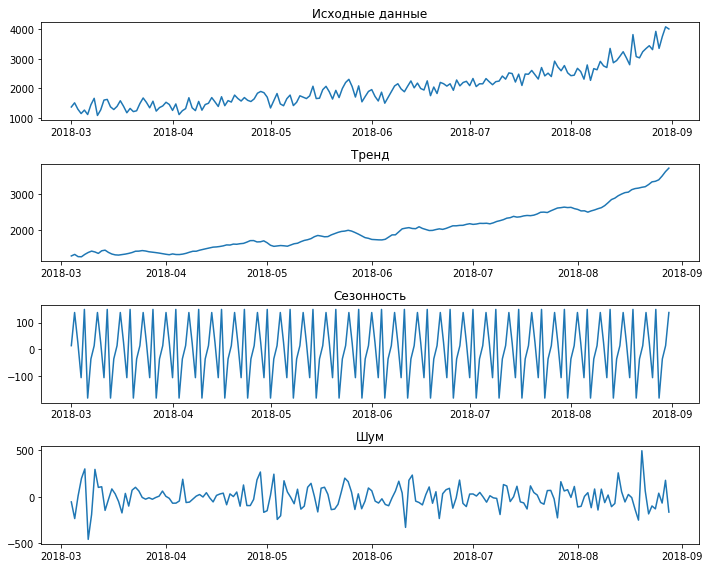

In [ ]:
ts_graph(data_resampled,'1D')

In [ ]:
data_resampled.head(24)['num_orders'].sum()

1364

In [ ]:
# Группируем данные по дням недели и вычисляем дисперсию
data_resampled_by_day = data_resampled.resample('1D').sum()
data_resampled_by_day['dayofweek'] = data_resampled_by_day.index.dayofweek
daily_var = data_resampled_by_day.groupby('dayofweek').agg({'num_orders':['std','mean','median']})
# Выводим результаты
print(daily_var)


           num_orders                     
                  std         mean  median
dayofweek                                 
0          710.606328  2165.923077  2000.0
1          619.852470  1848.269231  1667.5
2          643.207856  2010.115385  1857.0
3          648.460111  2055.851852  1893.0
4          676.183984  2187.370370  2079.0
5          583.447474  2012.346154  1942.5
6          550.649727  1895.807692  1796.5


In [ ]:
# рабочие часы
data_resampled['is_working_hour'] = np.where((data_resampled.index.hour >= 8)&(data_resampled.index.hour <=17),1,0)

In [ ]:
russia_holidays = holidays.Russia()

In [ ]:
def is_holiday(row):
    date_str = str(row.name.date())  # преобразование даты в строку
    if date_str in russia_holidays:
        return 1
    else:
        return 0



In [ ]:
data_resampled

,num_orders,is_working_hour
datetime,,
2018-03-01 00:00:00,124,0
2018-03-01 01:00:00,85,0
2018-03-01 02:00:00,71,0
2018-03-01 03:00:00,66,0
2018-03-01 04:00:00,43,0
...,...,...
2018-08-31 19:00:00,136,0
2018-08-31 20:00:00,154,0
2018-08-31 21:00:00,159,0


In [ ]:
def features_maker(data,
                   month_name,
                   dayofweek_name,
                   holiday_name,
                   hour_name,
                  month=True,
                  dayofweek=True,
                  holiday=True,
                  hour=True):
    assert isinstance(data, pd.DataFrame) or isinstance(data, pd.Series), "data parameter must be of type pd.DataFrame or pd.Series"
    assert isinstance(month, bool), "month parameter must be of type bool"
    assert isinstance(dayofweek, bool), "dayofweek parameter must be of type bool"
    assert isinstance(holiday, bool), "holiday parameter must be of type bool"
    if month:
        data[f'{month_name}'] = data.index.month
    if dayofweek:
        data[f'{dayofweek_name}'] = data.index.dayofweek
    if holiday:
        data[f'{holiday_name}'] = data.apply(is_holiday, axis=1)  # применение функции к каждой строке
    if hour:
        data[f'{hour_name}'] = data.index.hour




In [ ]:
data_resampled.head()

,num_orders,is_working_hour
datetime,,
2018-03-01 00:00:00,124,0
2018-03-01 01:00:00,85,0
2018-03-01 02:00:00,71,0
2018-03-01 03:00:00,66,0
2018-03-01 04:00:00,43,0


In [ ]:
features_maker(data=data_resampled,
               month_name='month',
               dayofweek_name='dayofweek',
               holiday_name='is_holiday',
               hour_name='hour',
               month=True,
               dayofweek=True,
               holiday=True,
               hour=True)


In [ ]:
data_resampled.head()

,num_orders,is_working_hour,month,dayofweek,is_holiday,hour
datetime,,,,,,
2018-03-01 00:00:00,124,0,3,3,0,0
2018-03-01 01:00:00,85,0,3,3,0,1
2018-03-01 02:00:00,71,0,3,3,0,2
2018-03-01 03:00:00,66,0,3,3,0,3
2018-03-01 04:00:00,43,0,3,3,0,4


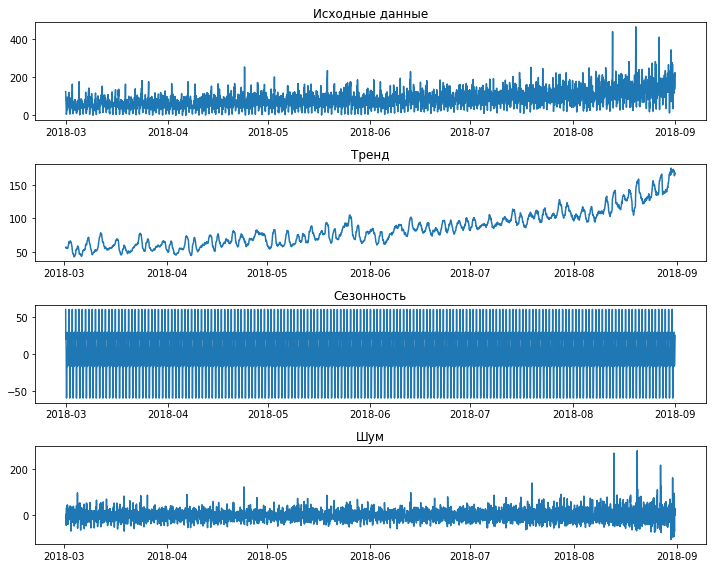

In [ ]:
ts_graph(data,'1H')

## Обучение

In [ ]:
night = [i for i in range(21,25)] + [i for i in range(0,5)]

In [ ]:
night

[21, 22, 23, 24, 0, 1, 2, 3, 4]

In [ ]:
data_night = data_resampled.query('hour in @night')

In [ ]:
rs=7

In [ ]:
def make_lag_rol(data,n_lag,n_roll):
    assert isinstance(data, pd.DataFrame), "data parameter must be of type pd.DataFrame"
    assert isinstance(n_lag, int), 'n_lag must be of type int'
    assert isinstance(n_roll, int),'n_roll must be of type int'
    tmp = data.copy()
    for i in range(1,n_lag+1):
        tmp[f'{i}_lag'] = tmp['num_orders'].shift(i)
    tmp[f'{n_roll}_rolling_mean'] = tmp['num_orders'].shift(1).rolling(n_roll).mean()
    return tmp

In [ ]:
%%time
data_lagged_rolled = data_resampled.copy()
rmse_lag_rol = {}

for lag, rolling in product(range(1, 31), range(3, 31)):
    data_lagged_rolled = make_lag_rol(data_lagged_rolled, lag, rolling)
    train, test = train_test_split(data_lagged_rolled, shuffle=False, test_size=0.1, random_state=rs)
    train.dropna(inplace=True)
    test.dropna(inplace=True)
    target_train = train['num_orders']
    features_train = train.drop(columns=['num_orders'], axis=1)

    target_test = test['num_orders']
    features_test = test.drop(columns=['num_orders'], axis=1)

    lr = LinearRegression()
    lr.fit(features_train, target_train)
    split = TimeSeriesSplit(n_splits=3)
    rmse = (np.mean(cross_val_score(estimator=lr, X=features_train, y=target_train,
                                   scoring='neg_root_mean_squared_error', cv=split)))*(-1)
    rmse_lag_rol[(lag, rolling)] = rmse
    data_lagged_rolled = data_lagged_rolled.drop(columns=data_lagged_rolled.columns[data_lagged_rolled.columns.str.contains('_lag|_rolling_median')], axis=1)



CPU times: user 4min 13s, sys: 10min 40s, total: 14min 53s
Wall time: 14min 54s


In [ ]:
rmse_lag_rol_df = pd.DataFrame.from_dict(rmse_lag_rol, orient='index')


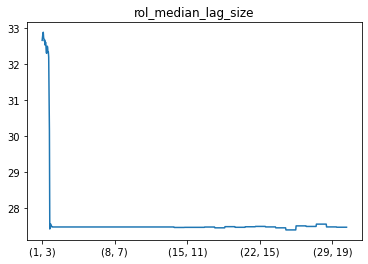

In [ ]:

rmse_lag_rol_df.plot(legend=None)
plt.title('rol_median_lag_size')
plt.show()

## Подбор lag

In [ ]:
min_value = min(rmse_lag_rol.values())

In [ ]:
min_value

27.38703755123001

In [ ]:
for key,value in rmse_lag_rol.items():
    if value == min_value:
        best=key
        break

In [ ]:
tmp = make_lag_rol(data_lagged_rolled, best[0], best[1])

In [ ]:
train, test = train_test_split(tmp, shuffle=False, test_size=0.1, random_state=rs)
train.dropna(inplace=True)
test.dropna(inplace=True)
target_train = train['num_orders']
features_train = train.drop(columns=['num_orders'], axis=1)

# Фильтрация данных по времени
test = test[test.index.hour.isin(night)]

# Удаление строк с пропущенными значениями
test.dropna(inplace=True)

# Разделение на целевую переменную и признаки
target_test = test['num_orders']
features_test = test.drop(columns=['num_orders'], axis=1)

In [ ]:
lr = LinearRegression()
lr.fit(features_train, target_train)

LinearRegression()

In [ ]:
split = TimeSeriesSplit(n_splits=3)


In [ ]:
(np.mean(cross_val_score(estimator=lr, X=features_train, y=target_train,
                                   scoring='neg_root_mean_squared_error', cv=split)))*(-1)

27.38703755123001

In [ ]:
pred_cat = lr.predict(features_test)
rmse_test_cat = (mean_squared_error(target_test, pred_cat))**0.5
print('RMSE на тестовой выборке:', rmse_test_cat)

RMSE на тестовой выборке: 61.72632610265541


## КэтБуст

In [ ]:
# Определяем параметры для подбора
params = {'learning_rate': [0.03, 0.1],
          'depth': [4, 6, 10],
          'l2_leaf_reg': [1, 5, 9]}

# Создаем экземпляр модели CatBoostRegressor
cb = CatBoostRegressor(verbose=False, loss_function='RMSE')


split = TimeSeriesSplit(n_splits=3)



In [ ]:
# Создаем экземпляр GridSearchCV и запускаем поиск по сетке
grid_search = RandomizedSearchCV(estimator=cb, param_distributions=params, cv=split, scoring='neg_root_mean_squared_error', n_jobs=-1)
grid_search.fit(features_train, target_train)

RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=<catboost.core.CatBoostRegressor object at 0x7fa63997c550>,
                   n_jobs=-1,
                   param_distributions={'depth': [4, 6, 10],
                                        'l2_leaf_reg': [1, 5, 9],
                                        'learning_rate': [0.03, 0.1]},
                   scoring='neg_root_mean_squared_error')

In [ ]:
# Выводим лучшие параметры и метрики на обучающей и тестовой выборках

rmse_train_cat = (-1 * grid_search.best_score_)
print('Лучшие параметры:', grid_search.best_params_)
print('RMSE на обучающей выборке:', rmse_train_cat)


Лучшие параметры: {'learning_rate': 0.03, 'l2_leaf_reg': 5, 'depth': 4}
RMSE на обучающей выборке: 35.9051742431515


## Случайный лес

In [ ]:


# Определяем параметры для подбора
params = {
    'n_estimators': [50, 100, 200],
    'max_depth': [4, 6, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

# Создаем экземпляр модели RandomForestRegressor
rf = RandomForestRegressor(random_state=rs)

split = TimeSeriesSplit(n_splits=3)



In [ ]:
# Создаем экземпляр RandomizedSearchCV и запускаем поиск по сетке
grid_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=params,
    cv=split,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

In [ ]:
grid_search.fit(features_train, target_train)


RandomizedSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
                   estimator=RandomForestRegressor(random_state=7), n_jobs=-1,
                   param_distributions={'max_depth': [4, 6, 10],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [50, 100, 200]},
                   random_state=42, scoring='neg_root_mean_squared_error')

In [ ]:
rmse_train_forest = (-1 * grid_search.best_score_)

# Выводим лучшие параметры и метрики на обучающей и тестовой выборках
print('Лучшие параметры:', grid_search.best_params_)
print('RMSE на обучающей выборке:', rmse_train_forest)


Лучшие параметры: {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 10}
RMSE на обучающей выборке: 35.844583216065026


## Регрессия

In [ ]:
# Определяем метрику, на основе которой будет производиться оценка качества
scorer = make_scorer(mean_squared_error, squared=False)

# Определяем параметры для подбора
param_grid = {'fit_intercept': [True, False],
              'normalize': [True, False]}

# Создаем экземпляр модели линейной регрессии
lin_reg = LinearRegression()


split = TimeSeriesSplit(n_splits=3)




In [ ]:
# Создаем экземпляр GridSearchCV
grid_search = GridSearchCV(estimator=lin_reg, param_grid=param_grid, cv=split, scoring=scorer)


In [ ]:
# и запускаем поиск по сетке
grid_search.fit(features_train, target_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=3, test_size=None),
             estimator=LinearRegression(),
             param_grid={'fit_intercept': [True, False],
                         'normalize': [True, False]},
             scoring=make_scorer(mean_squared_error, squared=False))

In [ ]:
# Выводим лучшие параметры и метрики на обучающей и тестовой выборках
rmse_lr_train = abs(grid_search.best_score_)
print('Лучшие параметры:', grid_search.best_params_)
print('RMSE на обучающей выборке:', rmse_lr_train)

Лучшие параметры: {'fit_intercept': True, 'normalize': True}
RMSE на обучающей выборке: 37.74430021655824


## Тестирование

In [ ]:
pd.DataFrame({'train_rmse_score':[rmse_train_cat,rmse_lr_train,rmse_train_forest]})


model_names = ['CatRegressor', 'LinearRegression', 'RandomForest']

# Создаем список с оценками RMSE для обучающего набора данных
train_rmse_scores = [rmse_train_cat, rmse_lr_train, rmse_train_forest]

# Создаем DataFrame с именами моделей в качестве индексов и оценками RMSE в качестве значений
train_rmse_df = pd.DataFrame({'RMSE Score': train_rmse_scores}, index=model_names)



In [ ]:
train_rmse_df

,RMSE Score
CatRegressor,35.905174
LinearRegression,37.744300
RandomForest,35.844583


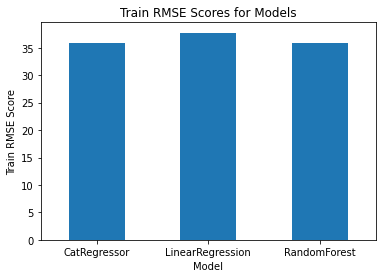

In [ ]:
# Строим график
ax = train_rmse_df.plot(kind='bar', rot=0, legend=None)

# Задаем название графика и осей
ax.set_title('Train RMSE Scores for Models')
ax.set_xlabel('Model')
ax.set_ylabel('Train RMSE Score')

# Отображаем график
plt.show()

In [ ]:
cb = CatBoostRegressor(learning_rate=0.3,l2_leaf_reg=0.03,depth=6,verbose=False)
cb.fit(features_train, target_train)

pred_cat = cb.predict(features_test)
rmse_test_cat = (mean_squared_error(target_test, pred_cat))**0.5
print('RMSE на тестовой выборке:', rmse_test_cat)

RMSE на тестовой выборке: 67.32920849479017


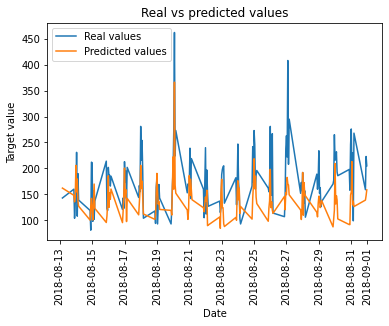

In [ ]:

plt.plot(target_test.index, target_test, label='Real values')
plt.plot(target_test.index, pred_cat, label='Predicted values')
plt.legend()
plt.xlabel('Date')
plt.ylabel('Target value')
plt.title('Real vs predicted values')
plt.xticks(rotation=90)

plt.show()

**Вывод:**

* Произведена загрузка и подготовка данных
* Выполнен анализ сезонности и тренда в данных
* Обнаружено большое количество шумов в данных
* Сделан вывод о том, что исследуемый временной ряд является стационарным
* Данные были разбиты на выборки
* Обучены три модели: RandomForest, Catboost и LinearRegression
* Наилучшая модель была выбрана для тестирования, и результаты показали, что RMSE меньше 48.